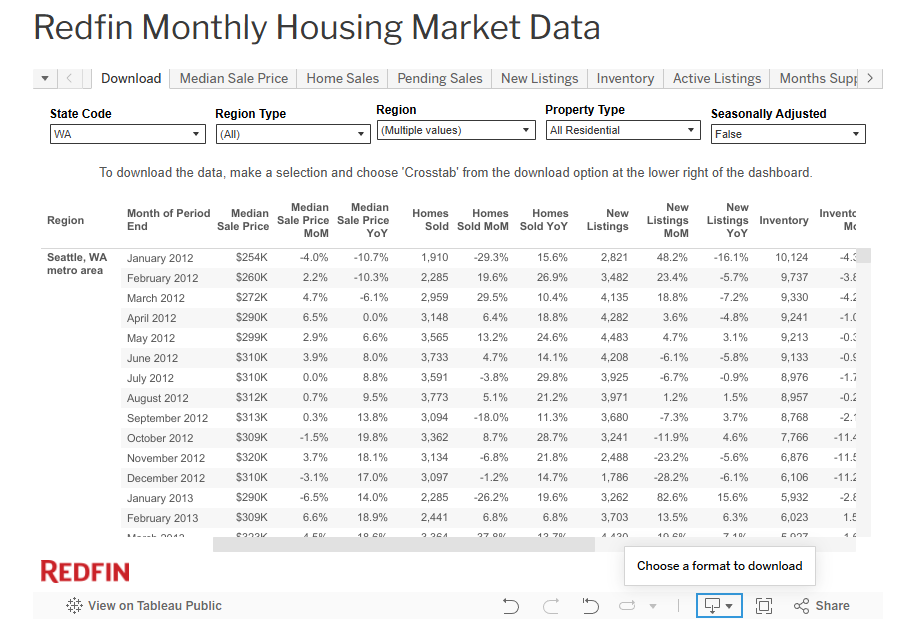

Download the data via Redfin for historical data. Here is the link that I used to gather this data. <br>
https://www.redfin.com/news/data-center/


In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [ ]:

# Load your dataset
df = pd.read_csv('./data/redfin-data.csv', parse_dates=['Month of Period End'], encoding='utf-16', sep='\t')
df.head()

### Only going to keep data that we want to keep for forecasting and features that might be interesting to investigate in the future. 

In [ ]:
df = df[['Region', 'Month of Period End', 'Median Sale Price', 'Homes Sold', 'Inventory', 'Days on Market', 'New Listings']]

In [ ]:
# Only looking at the Spokane, WA region just for this example. Along with other cleanup methods to prepare for modeling.
df = df[df['Region'] == 'Spokane, WA']
df['Price'] = df['Median Sale Price'].str.replace('$', '', regex=False)\
                             .str.replace('K', '', regex=False)\
                             .astype(float) * 1000
df['Price'] = df['Price'].astype(int)
df['Homes Sold'] = df['Homes Sold'].astype(int)
df['Inventory'] = df['Inventory'].str.replace(',', '', regex=False).astype(int)
df['New Listings'] = df['New Listings'].astype(int)
df = df.drop(columns=['Region', 'Median Sale Price'])


In [ ]:
df.head()

In [ ]:
# Sort by date
df = df.sort_values('Month of Period End')
df.set_index('Month of Period End', inplace=True)


In [ ]:
df.head()

In [ ]:
for lag in range(1, 13):  # use last 12 months
    df[f'price_lag_{lag}'] = df['Price'].shift(lag)

df.dropna(inplace=True)

In [ ]:
df[:-12]

In [ ]:
train = df[:-12]  # all but last year
test = df[-12:]   # last 12 months

X_train = train.drop('Price', axis=1)
y_train = train['Price']

X_test = test.drop('Price', axis=1)
y_test = test['Price']

In [ ]:
X_train

In [ ]:
model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

In [ ]:
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Housing Price Forecast')
plt.show()


Now that we see how good it has trained, let's see how it predicts future prices. 

In [ ]:
predictions = []
last_known = X_test.iloc[-1].copy()
print(last_known)
for _ in range(12):  # forecast 12 months
    input_data = last_known.values.reshape(1, -1)
    next_price = model.predict(input_data)[0]
    predictions.append(next_price)

    # shift lags and insert new prediction
    for i in range(12, 1, -1):
        last_known[f'price_lag_{i}'] = last_known[f'price_lag_{i-1}']
    last_known['price_lag_1'] = next_price


In [ ]:

# --- Create forecast time index ---
forecast_index = pd.date_range(start=df.index[-1] + pd.DateOffset(months=1), periods=12, freq='MS')
forecast_series = pd.Series(predictions, index=forecast_index)

In [ ]:
print(forecast_index)

In [ ]:

# --- Plot actual vs forecast ---
plt.figure(figsize=(10, 5))
plt.plot(df.index[-24:], df['Price'].iloc[-24:], label='Actual')
plt.plot(forecast_series.index, forecast_series, label='Forecast', linestyle='--')
plt.title("XGBoost Housing Price Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()